# Project part 3

## Installs and imports

In [331]:
%pip install Wikidata
%pip install NetworkX

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [383]:

import os
import tarfile
import datetime
import random
import json
import requests

import pandas as pd
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns 

from statistics import mean
from sklearn.metrics import jaccard_score
from wikidata.client import Client

from tqdm.auto import tqdm, trange

## Data loading and preprocessing 

Slightly modified version of milestone 2 submission.

Logic stays the same, modifications target mostly clarity/performance/my subjective sense of beauty of the code.

Important changes:

<ol>
  <li>I changed column names to only *lower case*</li>
</ol> 

In [399]:
DATA_FOLDER = 'data'
DB_FOLDER_NAME = 'MovieSummaries'
MOVIE_TABLE_PATH = os.path.join(DATA_FOLDER, DB_FOLDER_NAME, 'movie.metadata.tsv')
CHARACTER_TABLE_PATH = os.path.join(DATA_FOLDER, DB_FOLDER_NAME, 'character.metadata.tsv')

movies_columns = ['wikipedia movie id',
                  'freebase movie id',
                  'movie name',
                  'movie release date',
                  'movie box office revenue',
                  'movie runtime',
                  'movie languages',
                  'movie countries',
                  'movie genres']

characters_columns = ['wikipedia movie id',
                      'freebase movie id',
                      'movie release date',
                      'character name',
                      'actor dob',
                      'actor gender',
                      'actor height',
                      'actor ethnicity',
                      'actor name',
                      'actor age at movie release',
                      'freebase character/actor map id',
                      'freebase character id',
                      'freebase character map']

# Extract character.metadata.tsv and movie.metadata.tsv tables from MovieSummaries

file = tarfile.open(os.path.join(DATA_FOLDER, DB_FOLDER_NAME + '.tar.gz'))
file.extractall(DATA_FOLDER)
file.close()

df_movie = pd.read_csv(MOVIE_TABLE_PATH, sep ='\t', header = None,\
    names=movies_columns, na_values=['{}', ' '], lineterminator='\n')
df_character = pd.read_csv(CHARACTER_TABLE_PATH, sep ='\t', header = None,\
    names=characters_columns, na_values=' ', lineterminator='\n')


### Movie table preprocessing

In [417]:
# For movie and character identification we decided to use wikipedia id, so
# information from freebase are not usefull for us. We can remove columns regarding freebase.
df_movie = df_movie.drop(['freebase movie id'], 1)

# In our project we need movie release dates, so we can drop movies without release date.
# We drop only about 8 percent of movies.
print('Original number of movies: ', len(df_movie))
df_movie = df_movie.dropna(subset=['movie release date'])
print('Number of movies after droping empty dates: ', len(df_movie))

# Clean some columns which have freebase ID number apart from valuable information
def cleaning_function(column):
    string_cleaner = lambda val: ','.join(list(json.loads(val).values()))
    return [string_cleaner(val) if isinstance(val, str) else 'None' for val in column]

df_movie['movie languages'] = cleaning_function(df_movie['movie languages'])
df_movie['movie countries'] = cleaning_function(df_movie['movie countries'])
df_movie['movie genres'] = cleaning_function(df_movie['movie genres'])

# Clean date column, keep dates as just years of type int
def date_cleaning_function(column):
    string_cleaner = lambda val: val if len(val) <= 4 else val[0:4]
    dates = [string_cleaner(str(date)) for date in column]
    return np.array(dates, dtype=int)

df_movie['movie release date'] = date_cleaning_function(df_movie['movie release date'])


Original number of movies:  81741
Number of movies after droping empty dates:  74839


In [418]:
df_movie.head()

,wikipedia movie id,movie name,movie release date,movie box office revenue,movie runtime,movie languages,movie countries,movie genres
0,975900,Ghosts of Mars,2001,14010832.0,98.0,English Language,United States of America,"Thriller,Science Fiction,Horror,Adventure,Supe..."
1,3196793,Getting Away with Murder: The JonBenét Ramsey ...,2000,NaN,95.0,English Language,United States of America,"Mystery,Biographical film,Drama,Crime Drama"
2,28463795,Brun bitter,1988,NaN,83.0,Norwegian Language,Norway,"Crime Fiction,Drama"
3,9363483,White Of The Eye,1987,NaN,110.0,English Language,United Kingdom,"Thriller,Erotic thriller,Psychological thriller"
4,261236,A Woman in Flames,1983,NaN,106.0,German Language,Germany,Drama


### Character table preprocessing

In [400]:
# For character identification we decided to use wikipedia id, so
# information from freebase are not usefull for us. We can remove columns regarding freebase.
df_character = df_character.drop(['freebase movie id', 'freebase character/actor map id', 'freebase character id', 'freebase character map'], 1)

# In out project we need actor names, so we can drop character without their, actors name.
# We drop less then 1 percent of characters.
print('Original number of characters: ', len(df_character))
df_character = df_character.dropna(subset=['actor name'])
print('Number of characters after droping empty actor names: ', len(df_character))


Original number of characters:  450669
Number of characters after droping empty actor names:  449441


Ethnicities retrieving 

In [412]:
WIKIDATA_QUERY = """
SELECT DISTINCT ?item ?itemLabel WHERE {
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE]". }
  {
    SELECT DISTINCT ?item WHERE {
      ?item p:P646 ?statement0.
      ?statement0 (ps:P646) "%s".
    }
    LIMIT 100
  }
}
"""

def get_ethnicity(ethnicity_freebase_id):
    """Get the label of the freebase ID from Wikidata

    Args:
        freebase_id: the freebase ID to be decoded

    Returns: 
        entity.label, the corresponding label of the Wikidata ID
    """

    query = WIKIDATA_QUERY % ethnicity_freebase_id
    req = requests.get("https://query.wikidata.org/sparql",
                      params={"format": "json", "query": query})
    try:
        data = req.json()
        wikidata_id = data["results"]["bindings"][0]["itemLabel"]["value"]
    except:
        return np.nan

    return str(Client().get(wikidata_id, load=True).label)

def ethnicities_decoded(column):
    ethnicities = column.dropna().unique()
    print(f'We have {len(ethnicities)} unique ethnicities in actor table')
    decoded = []
    for ethnicity in tqdm(ethnicities):
        decoded.append(get_ethnicity(ethnicity))
    translator = dict(zip(ethnicities, decoded))
    return column.replace(translator)

df_character['actor ethnicity'] = ethnicities_decoded(df_character['actor ethnicity'])
ethnicity_found = df_character['actor ethnicity'].count()
print(f'After retrieving actor ethnicities we have {ethnicity_found} out of\
{len(df_character)} character ethnicities - so about {100 * ethnicity_found // len(df_character)} percent')

We have 479 unique ethnicities in actor table


A Jupyter Widget

In [369]:
df_character.head()

,wikipedia movie id,movie release date,character name,actor dob,actor gender,actor height,actor ethnicity,actor name,actor age at movie release
0,975900,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0
2,975900,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0
3,975900,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0
4,975900,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0


## Data visualization

## Graph construction

In [272]:
class GraphWrapper:
    '''
        Wrapper for networkx graph class, helps to make required operations easier

        The general idea of this wrapper is that, we load the whole graph while initializing
        and save it as 'graph_general' (not really whole, because we can specify years 
        of movies that interest us). Then, we have a part of the whole graph on which we want
        to focus - 'graph_part', it is a subgraph on 'graph_general' with all its nodes and
        its edges representing movies released in [tw_start, tw_start + tw_length - 1].

        So 'graph_part' is a part of 'graph_general' existing in specified time window. All
        other operations are made on 'graph_part'.
    
    '''

    def __init__(self, df_character, df_movie, release_year_min, release_year_max):
        self.graph_general = nx.Graph()
        self.graph_part = nx.Graph() # Graph used for sliding time window
        
        # Information on what movies do we keep in the graph_general
        self.release_year_min = release_year_min
        self.release_year_max = release_year_max

        # Information on what time window is graph_part focused on
        self.tw_start = 0
        self.tw_length = 0

        # Build graph_general nodes
        self.graph_general.add_nodes_from(df_character['actor name'].unique())

        # Build edges of graph_general
        for _, movie in tqdm(df_movie.iterrows(), total=len(df_movie)):
            wiki_movie_id = movie['wikipedia movie id']
            movie_release_date = movie['movie release date']
            if not release_year_min <= movie_release_date <= release_year_max:
                continue # Year outside of bounds
            
            connected = df_character[df_character['wikipedia movie id'] == wiki_movie_id]['actor name'].unique()
            new_edges = [(actor1, actor2, {'date': movie_release_date}) for actor1 in connected for actor2 in connected]
            self.graph_general.add_edges_from(new_edges)

        # Remove nodes with degree 0 from graph_general
        nodes_to_remove = list(filter(lambda entry: entry[1] == 0, self.graph_general.degree))
        nodes_to_remove = [node for node, _ in nodes_to_remove]
        self.graph_general.remove_nodes_from(nodes_to_remove)

        # Add some properties to graph nodes
        actors_movie_count = df_character['actor name'].groupby(df_character['actor name']).agg('count')
        nx.set_node_attributes(self.graph_general, actors_movie_count, name='movie count')

        # Build graph_part nodes
        self.graph_part.add_nodes_from(self.graph_general)

    def focus_on_tw(self, tw_start, tw_length):
        self.tw_start = tw_start
        self.tw_length = tw_length
        self.graph_part = nx.create_empty_copy(self.graph_general)

        for actor1, actor2, attr in self.graph_general.edges(data=True):
            if tw_start <= attr['date'] < tw_start + tw_length:
                self.graph_part.add_edge(actor1, actor2, date=attr['date'])

    def move_tw(self):
        '''
            Moving time window by 1 year.

            It is recommended to use this function to move time window by 1 year, instead of
            using 'focus_on_tw' with higher tw_start, as this one performs only the neccecary 
            modification of 'graph_part' edges.
        '''

        self.tw_start += 1
        
        edges_to_remove = list(filter(lambda x: x[2]['date'] == self.tw_start - 1, self.graph_part.edges(data=True)))
        self.graph_part.remove_edges_from(edges_to_remove)
    
        edges_to_add = list(filter(lambda x: x[2]['date'] == self.tw_start + self.tw_length - 1,\
            self.graph_general.edges(data=True)))
        self.graph_part.add_edges_from(edges_to_add)

    def k_neighborhood(self, node, k):
        ''' 
            Returns all nodes distant 'k' or less from 'node' in 'graph_part'

            This function has crazy high complexity with k, but we use
            it only with small values of k (<= 3)
        '''

        nodes = set([node])
        for step in range(k):
            new_nodes = set()
            for node in nodes:
                new_nodes = new_nodes.union(self.graph_part[node])
            nodes = new_nodes
        return nodes

    def k_neighborhoods(self, nodes, k):
        '''
            Returns dict, from node (in 'nodes') to its k-distant neighberhood
        '''

        result = {node: self.k_neighborhood(node, k) for node in nodes}
        return result


In [273]:
# FOR PERFORMANCE REASONS USE ONLY EDGES CREATED BY MOVIES RELEASED IN CERTAIN YEARS
RELEASE_YEAR_MIN = 1985
RELEASE_YEAR_MAX = 2005

gw = GraphWrapper(df_character, df_movie, RELEASE_YEAR_MIN, RELEASE_YEAR_MAX)


A Jupyter Widget

Number of nodes before: 134078
73914
Number of nodes after: 60164
Whole graph built from movies released between 1985 and 2005
Number of nodes in whole graph:  60164
Number of edges in whole graph:  874363


## Graph analysis

#### General graph properties 
We want to know a little more about the general graph properties and also how the number of edges change through the years.

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

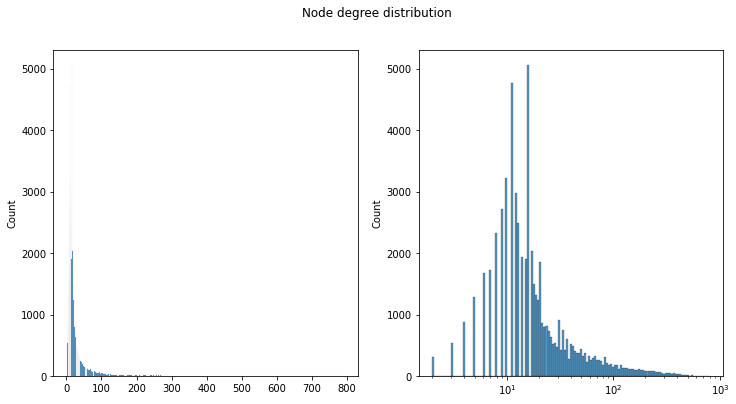

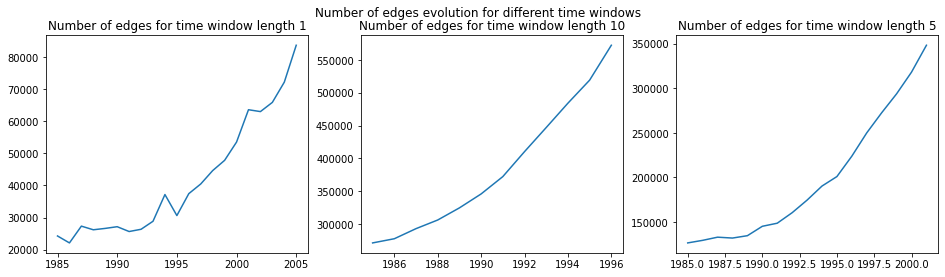

In [286]:
def plot_degree_distribution(gw):
    degrees = [deg for _, deg in gw.graph_general.degree]

    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    sns.histplot(degrees, ax=ax[0])
    sns.histplot(degrees, log_scale=True, ax=ax[1])
    fig.suptitle(f'Node degree distribution', fontsize=12)

def plot_tw_number_of_edges(gw, tw_length, tw_start_min, tw_end_max, ax):
    steps = tw_end_max - tw_start_min - tw_length + 2
    gw.focus_on_tw(tw_start_min, tw_length)

    numbers_of_edges = []
    for _ in tqdm(range(steps), total=steps):
        numbers_of_edges.append(gw.graph_part.number_of_edges())
        gw.move_tw()
    ax.plot(range(tw_start_min, tw_start_min + steps), numbers_of_edges)
    ax.set_title(f'Number of edges for time window length {tw_length}')
    
def plot_tw_for_different_lengths(gw, tw_lengths, tw_start_min, tw_end_max):
    fig, axs = plt.subplots(ncols=len(tw_lengths), figsize=(16,4))
    fig.suptitle(f'Number of edges evolution for different time windows')
    for i, tw_length in enumerate(tw_lengths):
        ax = axs[i] if len(tw_lengths) > 1 else axs
        plot_tw_number_of_edges(gw, tw_length, tw_start_min, tw_end_max, ax)
    plt.show()

# Print main graph info
print(f'Whole graph built from movies released between {gw.release_year_min} and {gw.release_year_max}')
print('Number of nodes in whole graph: ', gw.graph_general.number_of_nodes())
print('Number of edges in whole graph: ', gw.graph_general.number_of_edges())

plot_degree_distribution(gw)
plot_tw_for_different_lengths(gw, {1, 5, 10}, RELEASE_YEAR_MIN, RELEASE_YEAR_MAX)

#### k-distant neighborhoods
For some context, we would like to know how does the k-distant neighborhood size distribution look for different k. We check that for graph of movies made in time window [1998, 2003] (inclusive).

Number of nodes in part graph:  60164
Number of edges in part graph:  338484


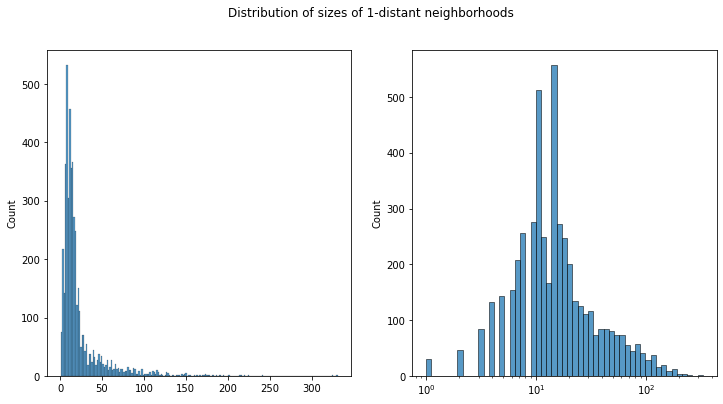

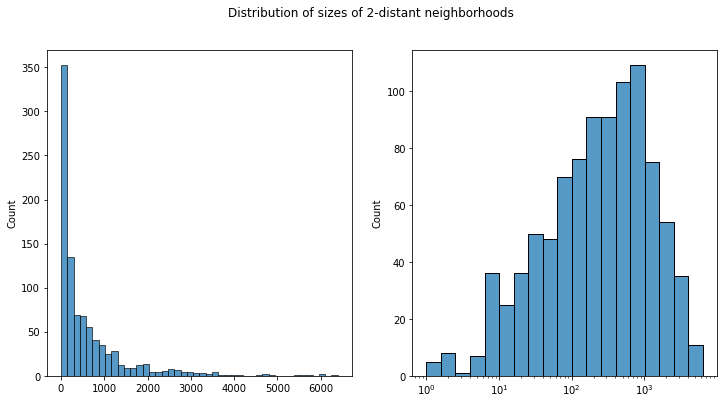

In [287]:
def plot_sizes_k_distant_neigberhoods(gw, k, used_nodes_num=-1):
    if used_nodes_num == -1: # Use all nodes
        used_nodes = gw.graph_part.nodes
    else:
        used_nodes = random.sample(gw.graph_part.nodes, used_nodes_num)
    
    sizes = np.array([len(gw.k_neighborhood(node, k)) for node in used_nodes])
    sizes = sizes[sizes != 0]

    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    sns.histplot(sizes, ax=ax[0])
    sns.histplot(sizes, log_scale=True, ax=ax[1])
    fig.suptitle(f'Distribution of sizes of {k}-distant neighborhoods', fontsize=12)

# Focus graph on targetted time window
gw.focus_on_tw(1998, 6)
print('Number of nodes in part graph: ', gw.graph_part.number_of_nodes())
print('Number of edges in part graph: ', gw.graph_part.number_of_edges())

# To reduce time, we check only part of nodes, (chosen randomly to preserve distribution shape)
plot_sizes_k_distant_neigberhoods(gw, 1, 10000)
plot_sizes_k_distant_neigberhoods(gw, 2, 2000)


We see, that size of 2-distant neighborhoods reach few thousand. These sizes grow exponentially with k. For practical reasons, we decided to operate later on a **value k set to 2**. Higher values would be impractical, both because of computation time, but also because with higher k these neighborhoods become extremely similar for different actors. Lower values also would be impractical, as every time window move would reform one's neighborhood greatly (a new movie would change it more drastically).

In [288]:
K = 2

Now we would like to check how much does the 2-distant neighborhood change for a given actor with every step (1 year move) of time window. We expect these changes to differ depending on how big the actor's neighborhood is. For that reason, we introduce notion of **active actors** that is, actors who have degree at least 100 in our graph ('graph_general' not just current time window). Thanks to our previous analysis, we know, that about 5% of all actors are **active actors**. These actors are generally the ones who play in more movies, or play in movies with more other actors. We will inspect the changes in neighborhood separately for active actors and for non-active actors. To measure the change we will use Jaccard similarity coefficient.

In [326]:
def jaccard_coefficient(set1, set2):
    if not set1 and not set2:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def get_samples(gw, degree_threshold=100, n=2000):
    ''' 
        Draw 'n' random actors, split them into two groups awdaw
        according to number of movies played
    '''
    used_nodes = random.sample(gw.graph_part.nodes, n)
    active_actors = list(filter(lambda actor: gw.graph_general.degree[actor] >= degree_threshold, used_nodes))
    non_active_actors = list(filter(lambda actor: gw.graph_general.degree[actor] < degree_threshold, used_nodes))
    return active_actors, non_active_actors

def get_jc_across_time(gw, nodes, tw_start, tw_length, steps_num):
    gw.focus_on_tw(tw_start, tw_length)
    old_neighborhoods = gw.k_neighborhoods(nodes, K)

    coeffs = []
    for _ in range(steps_num):
        gw.move_tw()
        new_neighborhoods = gw.k_neighborhoods(nodes, K)
        step_coeffs = [jaccard_coefficient(new_neighborhoods[node], old_neighborhoods[node]) for node in nodes]
        coeffs.append(mean(step_coeffs))
        old_neighborhoods = new_neighborhoods
    return coeffs

def plot_jc_for_moving_tw(gw, nodes, tw_start, tw_length, ax, steps_num): 
    coeffs = get_jc_across_time(gw, nodes, tw_start, tw_length, steps_num)
    
    ax.plot(list(range(tw_start, tw_start + steps_num)), coeffs, 'o')
    ax.set_xticks(list(range(tw_start, tw_start + steps_num)))
    ax.set_title(f'Time window length: {tw_length}')
    
def plot_jc_for_many_tw_lengths(gw, nodes, tw_start, tw_lengths, steps_num=6):
    fig, axs = plt.subplots(ncols=len(tw_lengths), figsize=(16,4))
    fig.suptitle(f'Jaccard coefficient between {K}-distant neighborhoods across time')
    for i, tw_length in enumerate(tqdm(tw_lengths)):
        ax = axs[i] if len(tw_lengths) > 1 else axs
        plot_jc_for_moving_tw(gw, nodes, tw_start, tw_length, ax, steps_num)
    plt.show()

# For performence reasone, we will inspect only some actors
n = 2000
aa, naa = get_samples(gw, n=n)
print(f'Split {n} nodes into groups, of {len(aa)} active actors and group of {len(naa)} non-active actors')

Split 2000 nodes into groups, of 110 active actors and group of 1890 non-active actors


In [327]:
# For performence reasons, we will sample just 1000 actors to check
n = 1000
aa, naa = get_samples(gw, n=n)
print(f'Split {n} nodes into groups, of {len(aa)} active actors and group of {len(naa)} non-active actors')

Split 1000 nodes into groups, of 57 active actors and group of 943 non-active actors


A Jupyter Widget

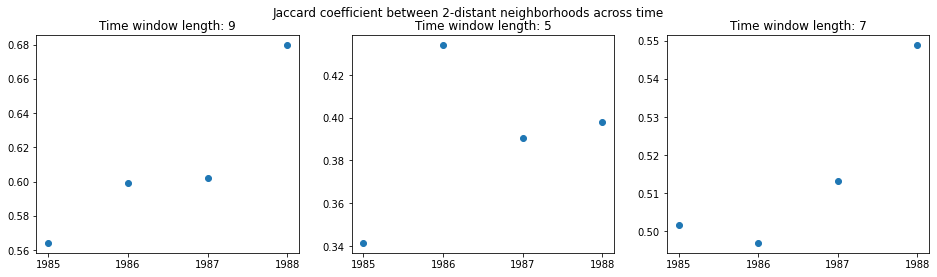

In [328]:
# First we plot for active actors
plot_jc_for_many_tw_lengths(gw, aa, tw_start=RELEASE_YEAR_MIN, tw_lengths={5,7,9}, steps_num=6)

A Jupyter Widget

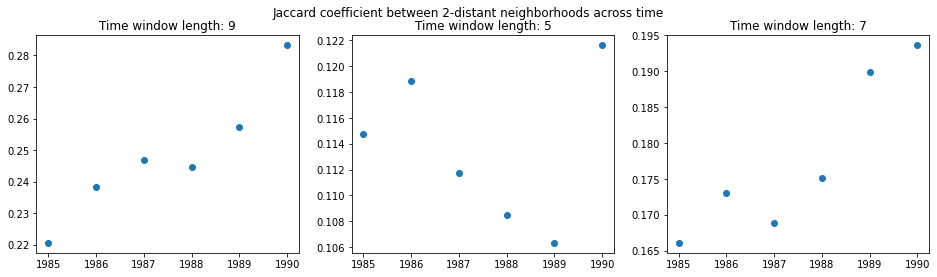

In [329]:
# Second we plot for non-active actors
plot_jc_for_many_tw_lengths(gw, naa, tw_start=RELEASE_YEAR_MIN, tw_lengths={5,7,9}, steps_num=6)

As expected, we see that similarity between actors neighberhoods between two consequitive time windows is higher for longer time windows. Additionally, we notice that when looking only on **active actors**, this similarity is higher then when looking on non-active actors.